# Super Smash Bros. Melee Replay Analysis Tutorial
## Sean Dwyer
### UID: 116567961, CMSC320 w/ John Dickerson 
![slippi.gg logo](slippi.png)

Super Smash Bros. Melee is a 2001 platform fighter developed by HAL Laboratory and published by Nintendo for the GameCube. Despite the release of 3 more Smash Bros. games in the series since the release of Melee, the game's competitive scene has thrived entirely off of grassroots organization. Players have been able to play eachother online using the Dolphin emulator and a *legally acquired* copy of the game. In 2020, a developer named Fizzi released a modification of the typical Doplhin emulator which introduced Rollback netcode to the online Melee experience. This branch of Dolphin was titled Slippi. One feature introduced by the new Slippi version of Dolphin was support for Replays, which you can use in the Slippi Launcher to rewatch and review previous games. Since Slippi's release, other developers have released tools to take advantage of the tools offered by Slippi. One such tool, py-slippi, allows us to interface with the Slippi replay files extremely in-depth. Using py-slippi I will go through my entire replay folder (replays since the release of slippi, mid 2020) and analyze my own gameplay, showing how one could go about doing this with their own .slp replay files. I main Fox.

---

Information about Slippi and its creators can be found at: https://slippi.gg/ and https://github.com/project-slippi/
<br>
Information about py-slippi and documentation can be found at: https://py-slippi.readthedocs.io/en/latest/index.html

In [3]:
import slippi as slp #importing py-slippi
import numpy as np #for various tools and math-related operations
import pandas as pd #for creation and manipulation of DataFrames
import os #for accessing replay files
import matplotlib.pyplot as plt #for fun charts and data visualization

## Data Wrangling
To get data from my replays, I have to go through each game individually and try to formulate ways to pick out specific info from the frame data and metadata given.
The method I chose to go with entailed going frame by frame through each replay and checking my Action State, which tells me which move I am currently doing. For each replay, I noted the opponent, the opponents character, how many times I used each move, how many times each move hit my opponent, the stage played, and other stats such as L-cancel percentage (explained later), and returned this data in a dictionary, which will later be appended as a column in a Pandas Dataframe.

In [83]:
def replay_to_df_row_all_attacks(replay_path):
    game = slp.Game(replay_path)
    port = 0
    #attack_dict = key:0 for key in [44:69]
    attack_dict = {44:0, 45:0,46:0,47:0,48:0,49:0,50:0,51:0,52:0,53:0,54:0,55:0,56:0,57:0,58:0,59:0,60:0,61:0,62:0,63:0,64:0,65:0,66:0,67:0,68:0,69:0}
    comfirm_dict = {1:0, 2:0, 6:0, 7:0, 8:0, 9:0, 10:0, 11:0, 12:0, 13:0, 14:0, 15:0, 16:0, 17:0, 18:0, 19:0, 20:0, 21:0}
    won = True
    stocks_taken = 0
    total = 0
    l_cancel_succ = 0
    l_cancel_total = 0
    hitlag = False
    if game.metadata.players[0].netplay == None:
        return None
    if not (game.frames[len(game.frames)-1].ports[port].leader.post.stocks == 0 or game.frames[len(game.frames)-1].ports[abs(port-1)].leader.post.stocks == 0):
        return None
    for player in game.metadata.players: #identify which port I am playing on
        if player != None:
            if player.netplay.code != "SEAN#839": #checking for my own Slippi code
                opponent_code = player.netplay.code
                opponent_char = list(player.characters)[0]
                port += 1
        else:
            break
    for frame in game.frames: #go through every frame in the replay
        if frame.ports[abs(port-1)].leader.post.flags != 274877906944: #dont count moves while opponent is dead

            post = frame.ports[port].leader.post #Move usage counter
            if (post.state_age == 1):
                state = post.state
                if (43 < state < 70):
                    attack_dict[state] += 1
                    total += 1
            
            if (post.flags == 0b10000000000000): #Hit Confirm dict
                if (hitlag == False):
                    last = post.last_attack_landed
                    if (last != None and (5 < last < 22 or 0 < last < 3)):
                        comfirm_dict[last] += 1
                        hitlag = True
            elif (hitlag):
                hitlag = False        

            if (post.l_cancel != None): #L cancel counter
                if (post.l_cancel == 1):
                    l_cancel_succ += 1
                l_cancel_total += 1
                
    if (game.frames[len(game.frames)-1].ports[port].leader.post.stocks == 0): #Win tracker
        won = False
    stocks_taken = 4 - game.frames[len(game.frames)-1].ports[abs(port-1)].leader.post.stocks #Stocks-taken counter
    if (l_cancel_total != 0):
        l_cancel_percentage = l_cancel_succ/l_cancel_total
    else:
        return None

    return {**{'opponent_char':opponent_char, 'opponent_code':opponent_code, 'stocks_taken':stocks_taken, 'stage':game.start.stage.name, 'win':won, 'l_can_per':l_cancel_percentage, 'total_atks':total, 'date':pd.to_datetime(game.metadata.date)}, **attack_dict, **comfirm_dict}

I will now apply this data wrangling method to every single file in my replay folder using the `os` library and put all the subsequent data into a DataFrame for further analysis. 

In [ ]:
df = pd.DataFrame()
char_dict = {0:'Mario', 1:'Fox', 2:'Capt Falcon', 3:'D.K.', 4:'Kirby', 5:'Bowser', 6:'Link', 7:'Sheik', 8:'Ness', 9:'Peach', 10:'Popo', 11:'Nana', 12:'Pikachu', 13:'Samus', 14:'Yoshi', 15:'Jigglypuff', 16:'Mewtwo', 17:'Luigi', 18:'Marth', 19:'Zelda', 20:'Young Link', 21:'Dr.Mario', 22:'Falco', 23:'Pichu', 24:'G&W', 25:'Ganon', 26:'Roy'}
for replay in os.listdir("D:\slippi replays"):
    path = os.path.join("D:\slippi replays", replay)
    print("analyzing " + replay)
    row = replay_to_df_row_all_attacks(path)
    if row != None:
        df = df.append({**row, **{'file':replay}}, ignore_index=True) #add replay file name to dict/DF row
df_orig = pd.DataFrame(df)
df_orig

*I am leaving the output for this block clear, since I had it print the name of every .slp file analyzed for debugging purposes.*

In [338]:
df = df_orig
df_orig

,+other,+jab,+dash_atk,+ftilt,+uptilt,+dtilt,+fsmash,+upsmash,+dsmash,+nair,...,dair,date,file,l_can_per,opp_char,opp_code,stage,stocks_taken,total_atks,win
0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,3.0,0.0,4.0,...,17.0,2020-07-08 01:00:14+00:00,Game_20200707T210014.slp,0.690476,18.0,FRTH#344,FINAL_DESTINATION,4.0,69.0,1.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,9.0,...,19.0,2020-07-08 01:04:18+00:00,Game_20200707T210418.slp,0.773585,18.0,FRTH#344,FOUNTAIN_OF_DREAMS,4.0,72.0,1.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,7.0,2020-07-08 01:08:21+00:00,Game_20200707T210821.slp,0.755102,18.0,FRTH#344,DREAM_LAND_N64,4.0,79.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,11.0,2020-07-08 01:13:01+00:00,Game_20200707T211301.slp,0.700000,18.0,FRTH#344,FOUNTAIN_OF_DREAMS,4.0,57.0,1.0
4,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,...,10.0,2020-07-08 01:17:11+00:00,Game_20200707T211711.slp,0.702703,18.0,FRTH#344,YOSHIS_STORY,3.0,55.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1224,0.0,0.0,2.0,0.0,2.0,0.0,1.0,1.0,0.0,0.0,...,15.0,2021-12-13 07:21:06+00:00,Game_20211213T022106.slp,0.793651,22.0,WHIT#463,BATTLEFIELD,3.0,90.0,0.0
1225,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,9.0,2021-12-13 07:25:31+00:00,Game_20211213T022531.slp,0.829787,22.0,WHIT#463,FINAL_DESTINATION,3.0,75.0,0.0
1226,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,13.0,2021-12-13 07:31:58+00:00,Game_20211213T023158.slp,0.741379,1.0,SMKE#872,DREAM_LAND_N64,4.0,103.0,1.0
1227,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,7.0,2021-12-13 07:35:39+00:00,Game_20211213T023539.slp,0.836735,1.0,SMKE#872,FOUNTAIN_OF_DREAMS,3.0,107.0,0.0


I now have raw data on every single move I used/hit, opponent/char I played, etc. To make the data more human-readable I will convert the enumeration of moves and characters to their actual names or an equivalent readable abbreviation.

In [205]:
df.columns = ['+other', '+jab', '+dash_atk', '+ftilt', '+uptilt', '+dtilt', '+fsmash', '+upsmash', '+dsmash', '+nair', '+fair', '+bair', '+uair', '+dair', '+neutral_b', '+side_b', '+up_b', '+down_b', 'jab', 'jab2', 'jab3', 'mjab', 'mjab_loop', 'mjab_end', 'dash_atk', 'ftilt_high', 'ftilt_highmid', 'ftilt_mid', 'ftilt_lowmid', 'ftilt_low', 'uptilt', 'dtilt', 'fsmash_high', 'fsmash_highmid', 'fsmash_mid', 'fsmash_lowmid', 'fsmash_low', 'upsmash', 'dsmash', 'nair', 'fair', 'bair', 'uair', 'dair', 'date', 'file', 'l_can_per', 'opp_char', 'opp_code', 'stage', 'stocks_taken', 'total_atks', 'win']
#df.columns = ['+other', '+jab', '+dash_atk', '+ftilt', '+uptilt', '+dtilt', '+fsmash', '+upsmash', '+dsmash', '+nair', '+fair', '+bair', '+uair', '+dair', '+neutral_b', '+side_b', '+up_b', '+down_b', 'jab', 'jab2', 'jab3', 'mjab', 'mjab_loop', 'mjab_end', 'dash_atk', 'ftilt_high', 'ftilt_highmid', 'ftilt_mid', 'ftilt_lowmid', 'ftilt_low', 'uptilt', 'dtilt', 'fsmash_high', 'fsmash_highmid', 'fsmash_mid', 'fsmash_lowmid', 'fsmash_low', 'upsmash', 'dsmash', 'nair', 'fair', 'bair', 'uair', 'dair', 'date', 'file', 'l_can_per', 'opp_char', 'opp_code', 'stage', 'stocks_taken', 'total_atks', 'win']
df = df.reindex(columns=['date', 'opp_char', 'opp_code', 'stage', 'win', 'stocks_taken', 'l_can_per', 'file', 'total_atks', 'jab','jab2', 'jab3', 'mjab', 'mjab_loop', 'mjab_end', 'dash_atk', 'ftilt_high', 'ftilt_highmid', 'ftilt_mid', 'ftilt_lowmid', 'ftilt_low', 'uptilt', 'dtilt', 'fsmash_high', 'fsmash_highmid', 'fsmash_mid', 'fsmash_lowmid', 'fsmash_low', 'upsmash', 'dsmash', 'nair', 'fair', 'bair', 'uair', 'dair', '+other', '+jab', '+dash_atk', '+ftilt', '+uptilt', '+dtilt', '+fsmash', '+upsmash', '+dsmash', '+nair', '+fair', '+bair', '+uair', '+dair', '+neutral_b', '+side_b', '+up_b', '+down_b'])
char_dict = {0:'Mario', 1:'Fox', 2:'Capt Falcon', 3:'D.K.', 4:'Kirby', 5:'Bowser', 6:'Link', 7:'Sheik', 8:'Ness', 9:'Peach', 10:'Popo', 11:'Nana', 12:'Pikachu', 13:'Samus', 14:'Yoshi', 15:'Jigglypuff', 16:'Mewtwo', 17:'Luigi', 18:'Marth', 19:'Zelda', 20:'Young Link', 21:'Dr.Mario', 22:'Falco', 23:'Pichu', 24:'G&W', 25:'Ganon', 26:'Roy'}
df = df.replace({'opp_char' : char_dict})
df.columns

Index(['date', 'opp_char', 'opp_code', 'stage', 'win', 'stocks_taken',
       'l_can_per', 'file', 'total_atks', 'jab', 'jab2', 'jab3', 'mjab',
       'mjab_loop', 'mjab_end', 'dash_atk', 'ftilt_high', 'ftilt_highmid',
       'ftilt_mid', 'ftilt_lowmid', 'ftilt_low', 'uptilt', 'dtilt',
       'fsmash_high', 'fsmash_highmid', 'fsmash_mid', 'fsmash_lowmid',
       'fsmash_low', 'upsmash', 'dsmash', 'nair', 'fair', 'bair', 'uair',
       'dair', '+other', '+jab', '+dash_atk', '+ftilt', '+uptilt', '+dtilt',
       '+fsmash', '+upsmash', '+dsmash', '+nair', '+fair', '+bair', '+uair',
       '+dair', '+neutral_b', '+side_b', '+up_b', '+down_b'],
      dtype='object')

Next, I will further clean up the data by dropping useless moves, like the sequential hits following a Jab, and moves that my character (Fox) cant do, such as angled Forward Smashes.

In [208]:
df_trim = df.drop(columns=['jab2', 'jab3', 'mjab', 'mjab_loop', 'mjab_end', 'fsmash_high', 'fsmash_highmid', 'fsmash_lowmid', 'fsmash_low'])
print(df_trim.columns)
df_trim

Index(['date', 'opp_char', 'opp_code', 'stage', 'win', 'stocks_taken',
       'l_can_per', 'file', 'total_atks', 'jab', 'dash_atk', 'ftilt_high',
       'ftilt_highmid', 'ftilt_mid', 'ftilt_lowmid', 'ftilt_low', 'uptilt',
       'dtilt', 'fsmash_mid', 'upsmash', 'dsmash', 'nair', 'fair', 'bair',
       'uair', 'dair', '+other', '+jab', '+dash_atk', '+ftilt', '+uptilt',
       '+dtilt', '+fsmash', '+upsmash', '+dsmash', '+nair', '+fair', '+bair',
       '+uair', '+dair', '+neutral_b', '+side_b', '+up_b', '+down_b'],
      dtype='object')


,date,opp_char,opp_code,stage,win,stocks_taken,l_can_per,file,total_atks,jab,...,+dsmash,+nair,+fair,+bair,+uair,+dair,+neutral_b,+side_b,+up_b,+down_b
0,2020-07-08 01:00:14+00:00,Marth,FRTH#344,FINAL_DESTINATION,1.0,4.0,0.690476,Game_20200707T210014.slp,69.0,0.0,...,0.0,4.0,0.0,2.0,2.0,5.0,0.0,0.0,1.0,5.0
1,2020-07-08 01:04:18+00:00,Marth,FRTH#344,FOUNTAIN_OF_DREAMS,1.0,4.0,0.773585,Game_20200707T210418.slp,72.0,0.0,...,0.0,9.0,0.0,10.0,8.0,6.0,0.0,0.0,0.0,10.0
2,2020-07-08 01:08:21+00:00,Marth,FRTH#344,DREAM_LAND_N64,1.0,4.0,0.755102,Game_20200707T210821.slp,79.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2020-07-08 01:13:01+00:00,Marth,FRTH#344,FOUNTAIN_OF_DREAMS,1.0,4.0,0.700000,Game_20200707T211301.slp,57.0,0.0,...,0.0,2.0,0.0,1.0,4.0,0.0,0.0,0.0,0.0,3.0
4,2020-07-08 01:17:11+00:00,Marth,FRTH#344,YOSHIS_STORY,0.0,3.0,0.702703,Game_20200707T211711.slp,55.0,0.0,...,0.0,2.0,0.0,9.0,3.0,7.0,0.0,0.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1224,2021-12-13 07:21:06+00:00,Falco,WHIT#463,BATTLEFIELD,0.0,3.0,0.793651,Game_20211213T022106.slp,90.0,1.0,...,0.0,0.0,0.0,6.0,4.0,0.0,0.0,0.0,1.0,5.0
1225,2021-12-13 07:25:31+00:00,Falco,WHIT#463,FINAL_DESTINATION,0.0,3.0,0.829787,Game_20211213T022531.slp,75.0,4.0,...,0.0,0.0,0.0,3.0,4.0,0.0,0.0,0.0,0.0,8.0
1226,2021-12-13 07:31:58+00:00,Fox,SMKE#872,DREAM_LAND_N64,1.0,4.0,0.741379,Game_20211213T023158.slp,103.0,4.0,...,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0
1227,2021-12-13 07:35:39+00:00,Fox,SMKE#872,FOUNTAIN_OF_DREAMS,0.0,3.0,0.836735,Game_20211213T023539.slp,107.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


# Data Visualization and Analysis
I will first make another dataframe where my averages for moves/winrate against every unique opponent is binned together, so, for specific analyses, players that I played against repeatedly wont be over-weighted.

In [222]:
df_unique = pd.DataFrame()
for oppcode in np.unique(df_trim['opp_code']):
    opp = df_trim.groupby('opp_code').get_group(oppcode)
    df_unique = df_unique.append({'opp_code':oppcode, 'win':np.average(opp['win']), 'games_played':len(opp), 'stocks_taken':np.average(opp['stocks_taken']), 'total_atks':sum(opp['total_atks']), 'jab':sum(opp['jab']), 'dash_atk':sum(opp['dash_atk']), '+dash_atk':sum(opp['+dash_atk']), 'ftilt_high':sum(opp['ftilt_high']), 'ftilt_highmid':sum(opp['ftilt_highmid']), 'ftilt_mid':sum(opp['ftilt_mid']), 'ftilt_lowmid':sum(opp['ftilt_lowmid']), 'ftilt_low':sum(opp['ftilt_low']), 'uptilt':sum(opp['uptilt']), 'dtilt':sum(opp['dtilt']), 'fsmash_mid':sum(opp['fsmash_mid']),'upsmash':sum(opp['upsmash']), 'dsmash':sum(opp['dsmash']), 'nair':sum(opp['nair']), 'fair':sum(opp['fair']), 'bair':sum(opp['bair']), 'uair':sum(opp['uair']), 'dair':sum(opp['dair']), '+other':sum(opp['+other']), '+jab':sum(opp['+jab']), '+dash_atk':sum(opp['+dash_atk']), '+ftilt':sum(opp['+ftilt']), '+uptilt':sum(opp['+uptilt']), '+dtilt':sum(opp['+dtilt']), '+fsmash':sum(opp['+fsmash']), '+upsmash':sum(opp['+upsmash']), '+dsmash':sum(opp['+dsmash']), '+nair':sum(opp['+nair']), '+fair':sum(opp['+fair']), '+bair':sum(opp['+bair']), '+uair':sum(opp['+uair']), '+dair':sum(opp['+dair']), '+neutral_b':sum(opp['+neutral_b']), '+side_b':sum(opp['+side_b']), '+up_b':sum(opp['+up_b']), '+down_b':sum(opp['+down_b'])}, ignore_index=True)
df_unique = df_unique.sort_values('games_played')
df_unique


,+bair,+dair,+dash_atk,+down_b,+dsmash,+dtilt,+fair,+fsmash,+ftilt,+jab,...,games_played,jab,nair,opp_code,stocks_taken,total_atks,uair,upsmash,uptilt,win
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,9.0,AA#468,4.000000,63.0,11.0,7.0,1.0,1.000000
296,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,5.0,RESL#307,1.000000,28.0,5.0,2.0,0.0,0.000000
227,1.0,1.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,3.0,10.0,MAKA#666,4.000000,85.0,4.0,3.0,15.0,1.000000
109,2.0,1.0,0.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,14.0,FLOCK#0,3.000000,70.0,14.0,2.0,4.0,0.000000
293,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,4.0,17.0,RECK#151,4.000000,77.0,7.0,5.0,11.0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
392,36.0,41.0,3.0,100.0,1.0,0.0,1.0,0.0,4.0,2.0,...,14.0,6.0,127.0,WIGG#327,2.857143,868.0,154.0,81.0,42.0,0.357143
72,31.0,56.0,3.0,33.0,3.0,0.0,6.0,27.0,5.0,16.0,...,21.0,75.0,110.0,DADD#684,3.523810,1600.0,51.0,1.0,176.0,0.571429
176,75.0,55.0,14.0,117.0,2.0,0.0,3.0,7.0,0.0,15.0,...,22.0,47.0,327.0,JINO#228,3.363636,1690.0,142.0,144.0,135.0,0.545455
364,57.0,38.0,7.0,132.0,1.0,2.0,43.0,1.0,21.0,13.0,...,65.0,325.0,327.0,TOBA#455,2.815385,5875.0,543.0,164.0,86.0,0.353846


Text(0.5, 1.0, 'Games played over')

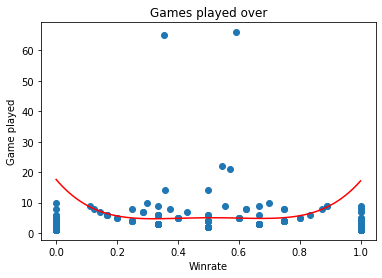

In [253]:
plt.scatter(df_unique['win'], df_unique['games_played'])
unique_games = []
unique_wr = []
for index, row in df_unique.iterrows():
    if 0 < row['win'] < 1 and row['games_played'] < 50 and row['games_played'] > 1:
        unique_games.append(row['games_played'])
        unique_wr.append(row['win'])
fit = np.polyfit(unique_wr, unique_games, deg=4)
line = np.linspace(0, 1, 100)
plt.plot(line, np.polyval(fit, line), color='r')
plt.xlabel("Winrate")
plt.ylabel("Game played")
plt.title("Games played over")


In this chart, I used a scatter plot to chart how many matches I and the opponent played against eachother over the winrate versus that opponent. I dropped outliers like my two friends who I have over 60 games played against and "one-and-done" games where either I or the opponent left after a singular game. I also dropped opponents who I either beat or lost to 100% of the time since there is high variance among whether I/my opponent stay in that scenario. As you can see, for opponents where we traded games, a fourth degree polynomial function fits the data relatively well.

Text(0.5, 1.0, '% Nair Conversions')

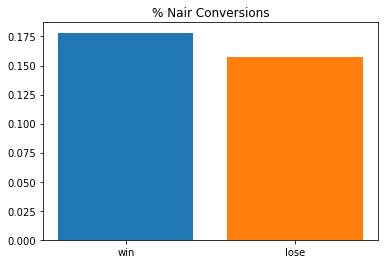

In [167]:
#print(np.unique(df_trim['win']))
wins = df_trim.groupby(['win']).get_group(1)
plt.bar(height=sum(wins['+nair'])/sum(wins['nair']), x='win')
lose = df_trim.groupby(['win']).get_group(0)
plt.bar(height=sum(lose['+nair'])/sum(lose['nair']), x='lose')
plt.title("% Nair Conversions")

In this bar chart, we can see the percent of Neutral Airs I threw out that ended up hitting the opponent. For fox, Neutral Air (nair) is one of the most common neutral openers. So much so that it can be the downfall of many a fox who are unable to mix-up their approaches:
!(nairplane)[nairplane.gif]
*"The plight of the aggressive Fox" by @krogermagi on Twitter*

In [ ]:
wins['fsmash'] = wins['fsmash_mid']
wins.drop(columns='fsmash_mid')
lose['fsmash'] = lose['fsmash_mid']
lose.drop(columns='fsmash_mid')
#renaming columns so my next code block works easily, also Fox doesnt have angled fsmashes

<function matplotlib.pyplot.show(close=None, block=None)>

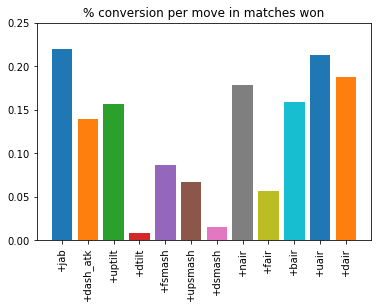

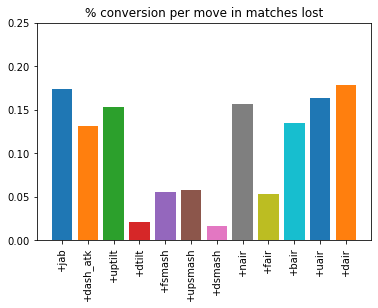

In [282]:
plt.figure(0)
for col in wins[['+jab', '+dash_atk', '+uptilt',
       '+dtilt', '+fsmash', '+upsmash', '+dsmash', '+nair', '+fair', '+bair',
       '+uair', '+dair']]:
       if sum(wins[col[1::]]) != 0:
           plt.bar(x=col, height=(sum(wins[col]) / sum(wins[col[1::]])))
plt.title("% conversion per move in matches won")
plt.xticks(rotation=90)
plt.ylim(0, .25)
plt.show
plt.figure(1)
for col in lose[['+jab', '+dash_atk', '+uptilt',
       '+dtilt', '+fsmash', '+upsmash', '+dsmash', '+nair', '+fair', '+bair',
       '+uair', '+dair']]:
       if sum(lose[col[1::]]) != 0:
           plt.bar(x=col, height=(sum(lose[col]) / sum(lose[col[1::]])))
plt.title("% conversion per move in matches lost")
plt.xticks(rotation=90)
plt.ylim(0, .25)
plt.show


In the above pie charts, you can view the percantage of conversions for each normal attack in the game based on whether I won or lost. There isn't much overall difference in my conversion rate per move in the win/loss charts, but one notable change is that in matches I won, I had ~2% higher conversion of "uair"/up air, which is a strong combo and kill move.

<ipython-input-290-db4a4285b0f1>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  curr['fsmash'] = curr['fsmash_mid']


0.11112309110846487
0.10558683610486275
0.10648425569417415
0.11091697412466738
0.12384475823704967


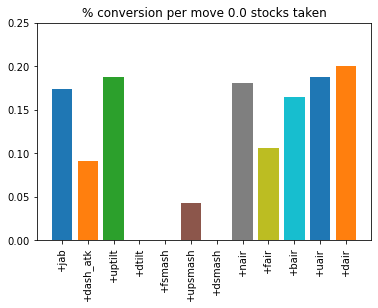

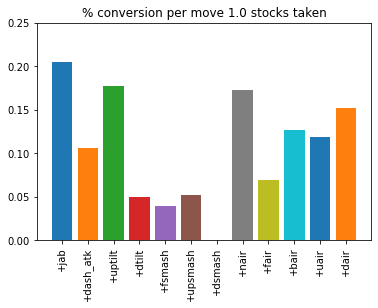

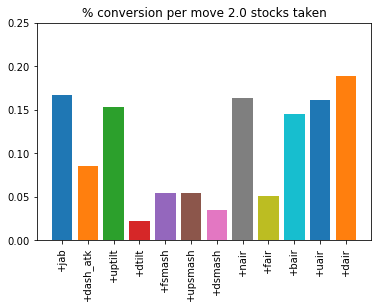

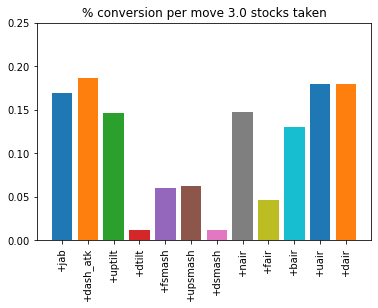

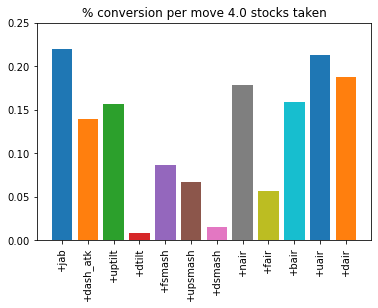

In [290]:
figure = 0
for stock_count in np.unique(df_trim['stocks_taken']):
    percents = []
    curr = df_trim.groupby('stocks_taken').get_group(stock_count)
    curr['fsmash'] = curr['fsmash_mid']
    plt.figure(figure)
    figure+=1
    for col in curr[['+jab', '+dash_atk', '+uptilt',
        '+dtilt', '+fsmash', '+upsmash', '+dsmash', '+nair', '+fair', '+bair',
        '+uair', '+dair']]:
        if sum(curr[col[1::]]) != 0:
            percents.append(sum(curr[col]) / sum(curr[col[1::]]))
            plt.bar(x=col, height=(sum(curr[col]) / sum(curr[col[1::]])))
    plt.title("% conversion per move " + str(stock_count) + " stocks taken")
    plt.xticks(rotation=90)
    plt.ylim(0, .25)
    plt.show
    print(np.average(percents))

In each of the above charts, you can again see the percentage conversion for each normal attack in the game. As you can see, the variety of moves converted increases depending on how many stocks I took. 

Text(0.5, 1.0, 'Move Conversion % over Stocks Taken')

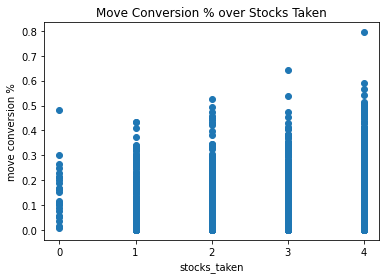

In [342]:
stocks_taken = []
conversion_per = []
for index, row in df_trim.iterrows():
    percents = []
    curr = row
    curr['fsmash'] = curr['fsmash_mid']
    for col in ['+jab', '+dash_atk', '+uptilt',
        '+dtilt', '+fsmash', '+upsmash', '+dsmash', '+nair', '+fair', '+bair',
        '+uair', '+dair']:
        if row[col[1::]] != 0:
            percents.append(row[col] / row[col[1::]])
    stocks_taken.append(row['stocks_taken'])
    conversion_per.append(np.average(percents))
plt.scatter(stocks_taken, conversion_per)
plt.xlabel('stocks_taken')
plt.ylabel('move conversion %')
plt.xticks(ticks=[0,1,2,3,4])
plt.title('Move Conversion % over Stocks Taken')

In the above scatterplot, I plot my conversion percentage for all normal moves over how many stocks I took from the opponent in the match. From this scatter plot, it seems clear that there is an increase in successful conversions per stocks taken. I will now apply a linear regression machine learning model to this data to test this hypothesis.

[[0.00866741]]


Text(0.5, 1.0, 'Move Conversion % over Stocks Taken')

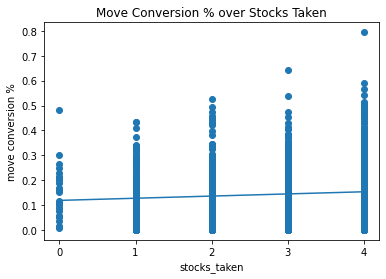

In [343]:
from sklearn import linear_model
#conv_arr = np.array([np.array(dat.groupby('stocks_taken').get_group(0).conversion_per), np.array(dat.groupby('stocks_taken').get_group(1).conversion_per), 
#np.array(dat.groupby('stocks_taken').get_group(2).conversion_per), np.array(dat.groupby('stocks_taken').get_group(3).conversion_per), np.array(dat.groupby('stocks_taken').get_group(4).conversion_per)])
reg = linear_model.LinearRegression()
linreg = reg.fit([[x] for x in stocks_taken], [[y] for y in conversion_per])
plt.scatter(stocks_taken, conversion_per)
plt.plot([[0],[1],[2],[3],[4]], [y for [y] in linreg.predict([[0],[1],[2],[3],[4]])])
print(linreg.coef_)
plt.xlabel('stocks_taken')
plt.ylabel('move conversion %')
plt.xticks(ticks=[0,1,2,3,4])
plt.title('Move Conversion % over Stocks Taken')


There does seem to be a slight positive correlation between successful conversions of moves and stocks taken, but I expected it to be much more directly correlated initially because of the way the scatter plot illustrated the data. To get a better sense of the data, lets graph the same points using Violin plots.

Text(0.5, 1.0, 'Move Conversion % over Stocks Taken')

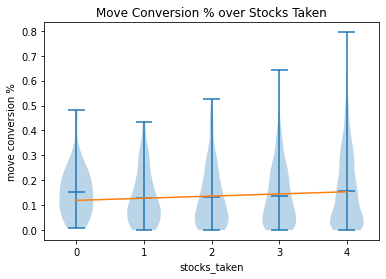

In [344]:
dat = pd.DataFrame(columns=['stocks_taken', 'conversion_per'])
dat['stocks_taken'] = stocks_taken
dat['conversion_per'] = conversion_per
data = [dat.groupby('stocks_taken').get_group(x).reindex().conversion_per for x in [0,1,2,3,4]]
plt.violinplot(data, [0,1,2,3,4], showmeans=True)
plt.plot([[0],[1],[2],[3],[4]], [y for [y] in linreg.predict([[0],[1],[2],[3],[4]])])
plt.xlabel('stocks_taken')
plt.ylabel('move conversion %')
plt.title('Move Conversion % over Stocks Taken')

In this graph, we can clearly see how the bulk of the data is clustered togeter at the bottom of each group, even moreso than we could see in the scatter plots. This explains why the correlation was not as strong as expected, and why the coefficient was so low.

<function matplotlib.pyplot.show(close=None, block=None)>

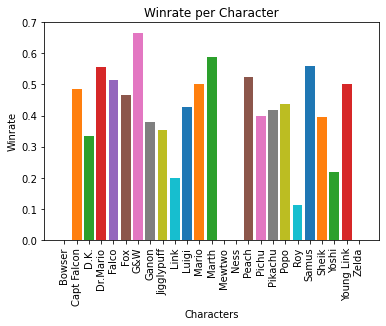

In [355]:
for char in np.unique(df_trim['opp_char']):
    curr = df_trim.groupby(['opp_char']).get_group(char)
    #np.average(curr.win)
    #print(char, ": ", np.average(curr.win))
    plt.bar(x=char, height=np.average(curr.win))
plt.xticks(rotation=90)
plt.xlabel('Characters')
plt.ylabel('Winrate')
plt.title('Winrate per Character')
plt.show


In this plot, we can see my overall winrate versus every single character in the game. Ironically, my winrate versus worse characters (Link, Pichu, D.K., Roy) is usually quite low, since only players who are extremely skillful usually chose to play a low-tier (often I am playing against a much better player's seconday character in these instances)

<function matplotlib.pyplot.show(close=None, block=None)>

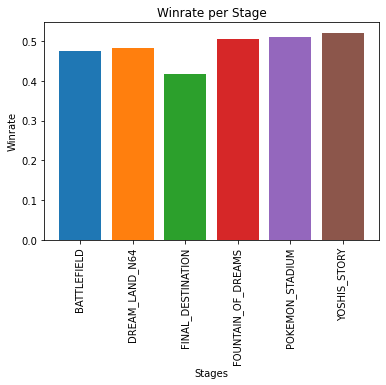

In [356]:
for stage in ['BATTLEFIELD', 'DREAM_LAND_N64', 'FINAL_DESTINATION', 'FOUNTAIN_OF_DREAMS', 'POKEMON_STADIUM', 'YOSHIS_STORY']:
    plt.bar(x=stage, height=np.average(df_trim.groupby('stage').get_group(stage).win))
plt.xticks(rotation=90)
plt.xlabel('Stages')
plt.ylabel('Winrate')
plt.title('Winrate per Stage')
plt.show

In the above bar chart, we can see my win rate against all oppononet/characters on the stages legal in competitive play. To get a better sense of the data, lets break it down by character:

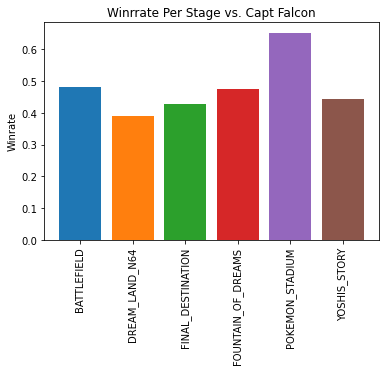

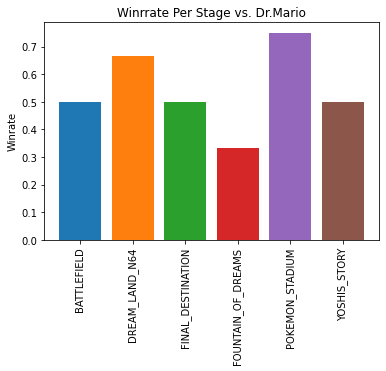

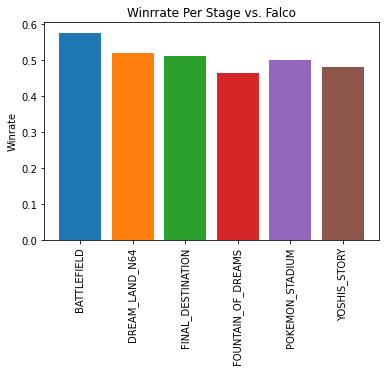

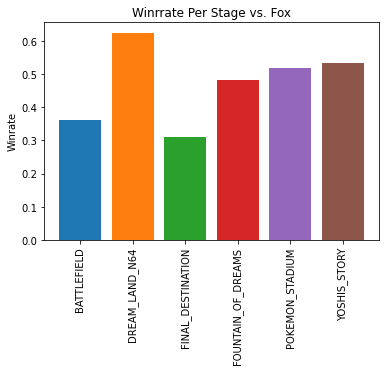

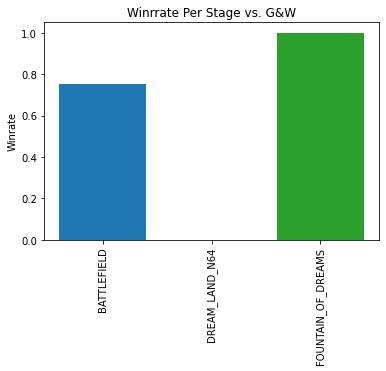

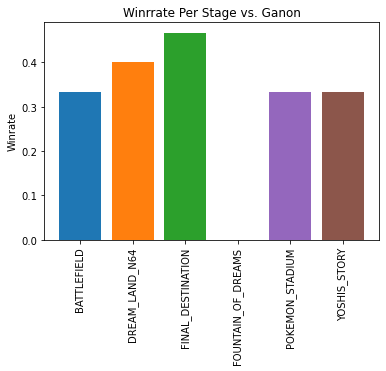

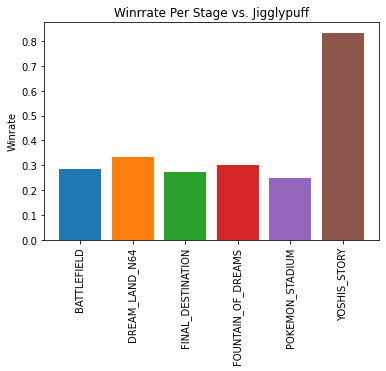

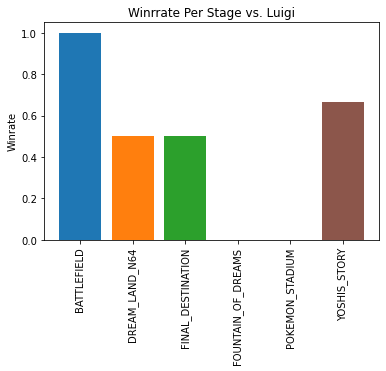

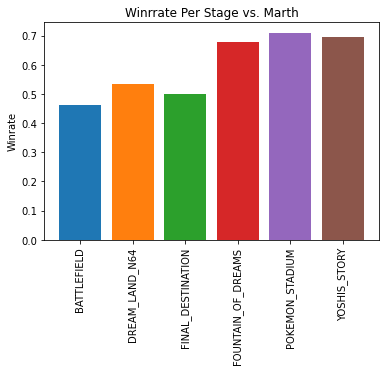

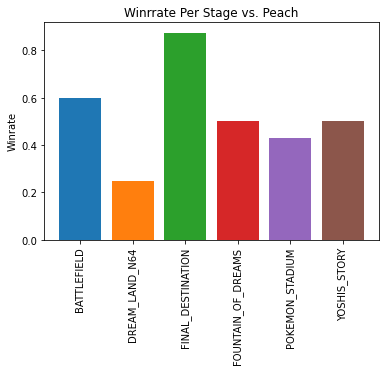

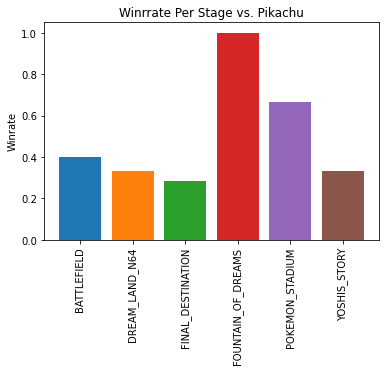

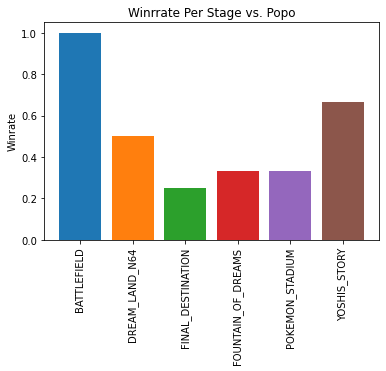

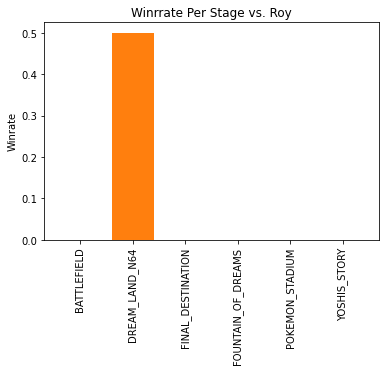

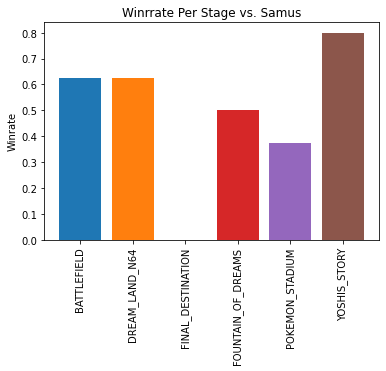

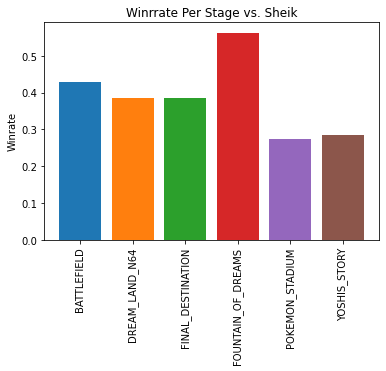

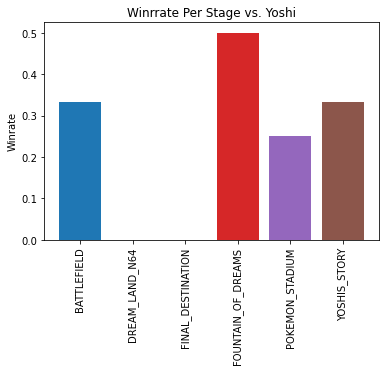

In [357]:
figure = 0
for char in np.unique(df_trim.opp_char):
    curr_char = df_trim.groupby('opp_char').get_group(char)
    if len(curr_char) > 5:
        plt.figure(figure)
        figure+=1
        for stage in [x for x in np.unique(curr_char['stage']) if x in ['BATTLEFIELD', 'DREAM_LAND_N64', 'FINAL_DESTINATION', 'FOUNTAIN_OF_DREAMS', 'POKEMON_STADIUM', 'YOSHIS_STORY']]:
            #height = np.average(curr_char.groupby('stage').get_group(stage).win)
            plt.bar(x=stage, height=np.average(curr_char.groupby('stage').get_group(stage).win))
        plt.xticks(rotation=90)
        plt.title("Winrrate Per Stage vs. " + char)
        plt.ylabel('Winrate')
        plt.show
        

In the above charts, we can see my win-rate per stage against all of the typical characters used in competitive play (and G&W and Roy). Several conclusions about which stages I am best at vs. specific chars can be drawn. Against peach, my win-rate is much higher on Final Destination than any other stage. The same can be said for Pikachu and Fountain of Dreams. One especially notable instance is my win-rate versus Jigglypuff on Yoshi's Story. This increase makes sense, as Jigglypuff can die early from stong hits, and Yoshi's Story is the smallest legal stage in the game. I also can see that my winrate versus other Foxs is much higher on Dreamland than any other stage. I can use this information to counter-pick in competitive play in the future.

Text(0.5, 1.0, 'L-Canel Percentage over Time')

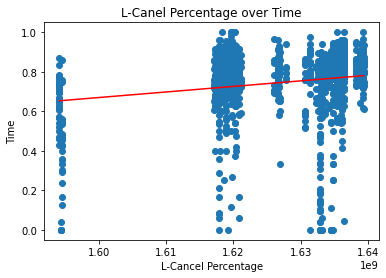

In [358]:
from datetime import datetime
x_axis_lcan = [x.timestamp() for x in df_trim['date']] #datetime lib imported for .timestamp() method so we can easily use the date of a match as the x axis for l-cancels/time
plt.scatter(x_axis_lcan, df_trim['l_can_per'])
fit = np.polyfit(x_axis_lcan, df_trim['l_can_per'], 1)
line = np.linspace(x_axis_lcan[0], x_axis_lcan[len(x_axis_lcan)-1], 100)
plt.plot(line, fit[0]*line+fit[1], color='r')
plt.xlabel('L-Cancel Percentage')
plt.ylabel('Time')
plt.title('L-Canel Percentage over Time')


The above chart shows a increase in overall average L-Cancel percentage. In Melee, every time you land while using a non-special attack move (nair, fair, uair, dair, bair), you are put into a "landing-lag" state. If you hit the "L" button immediately before landing, your landing time is cut in half. Ideally, you want to hit 100% of L-Cancels. This chart shows my improvement in terms of hitting l-cancels between my matches in mid-2020 (when Slippi was released) to late 2021. Plotting this line of best fit is the same as applying a linear regression to the data, as can be seen in the next code block:

Text(0.5, 1.0, 'L-Canel Percentage over Time')

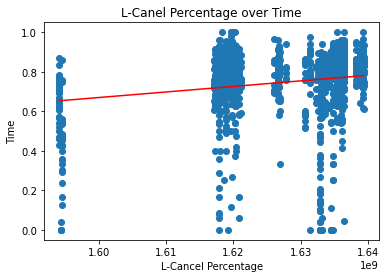

In [359]:
reg = linear_model.LinearRegression()
fit = reg.fit([[x] for x in x_axis_lcan], [[y] for y in df_trim['l_can_per']])
plt.scatter(x_axis_lcan, df_trim['l_can_per'])
plt.plot(x_axis_lcan, [y for [y] in fit.predict([[x] for x in x_axis_lcan])], color='r')
plt.xlabel('L-Cancel Percentage')
plt.ylabel('Time')
plt.title('L-Canel Percentage over Time')

## Conclusion
Using the tools made by various community memebers, interfacing with data from my replays is quite simple. I was hoping to be able to get more information about usage of special moves, such as Fox's Shine, which is another extremely common neutral opener. Unfourtanately, the way shine and other special moves are implemented in Melee varies from the way the normal attacks are implemented. Perhaps with more work in the future, I can make a standalone program for people to feed all their replays into for in-depth analysis.
Having data on which stages I am best at in specific matches is extremely useful for future tournament play. Not only can I use to to counter-pick in sets, but I can use this analysis to influence how I practice moving forward (against which chars and on which stages).